# Activity-based Travel Pattern Identification 
<hr>

This notebook attempts to identify the travel patterns based on different activities performed by the passengers according to three main criteria. </br> 
        1. Temporal regularities  - Variation of the number of trips in each time of a day and day of the week </br>
        2. Trip length distributions  - Reletive frequency distribution of trips </br>
        3. Spatial dynamics - Frequency distribution from hexagon regions within a study area </br> 
        
        
<b> Notes: </b> </br> 
passenger trips should be in gps records including the orign and destination clearly </br> 
please change the variable, feature and  file names according to your requirement  </br> 
feather file format has been used to efficient data transfers 

## Package import  

In [1]:
# general packages
import pandas as pd 
import numpy as np

In [35]:
# visualization packages 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [3]:
# remove the default='warns'
pd.options.mode.chained_assignment = None 

In [4]:
# autocompletion magic command 
%config Completer.use_jedi = False

## File import 

In [5]:
tripdata = pd.read_feather('complete_output.feather')

In [6]:
tripdata.head()

trip_id                                       passenger_id  pickup_lat  \
0  188700502  0029f4801cc292515e7307f4c06dfcaee6932662fb8eae...     6.94533   
1  188867625  0029f4801cc292515e7307f4c06dfcaee6932662fb8eae...     6.94534   
2  189052841  0029f4801cc292515e7307f4c06dfcaee6932662fb8eae...     6.94537   
3  188504553  0031191d45dd411b9df4cab466a3cb21667f785a4f852f...     6.89407   
4  188555640  0031191d45dd411b9df4cab466a3cb21667f785a4f852f...     6.89407   

   pickup_long  dropoff_lat  dropoff_long  actual_pickup_time  \
0      79.8584      6.89516       79.8532 2019-11-05 06:26:00   
1      79.8584      6.89515       79.8531 2019-11-06 06:29:00   
2      79.8584      6.89504       79.8530 2019-11-07 06:29:00   
3      79.8951      6.90638       79.8774 2019-11-04 06:28:00   
4      79.8951      6.90930       79.8759 2019-11-04 11:00:00   

          pickup_time           drop_time Trip purpose  
0 2019-11-05 06:22:00 2019-11-05 06:44:00    education  
1 2019-11-06 06:21:00 2019-11-06 06:48:00    education  
2 2019-11-07 06:22:00 2019-11-07 06:48:00    education  
3 2019-11-04 06:19:00 2019-11-04 06:55:00    education  
4 2019-11-04 10:54:00 2019-11-04 11:16:00         work

In [7]:
# number of activities of the total dataset
tripdata['Trip purpose'].value_counts()

shopping        26830
personal        20697
residential     18207
dining          11058
medical          9562
work             7765
education        6059
transit          3808
recreational     2724
NA                779
multiple          582
Name: Trip purpose, dtype: int64

## Temporal regularities of trips 

In [142]:
# set the required purpose (activity)
trip_purpose = 'work'

In [143]:
# select data for the purpose 
purpose_trip_data = tripdata[tripdata['Trip purpose'] == trip_purpose]

In [144]:
# set the time format 
purpose_trip_data['drop_time'] = pd.to_datetime(purpose_trip_data['drop_time'])

In [145]:
# input the name of the day 
purpose_trip_data['day_name'] = purpose_trip_data['drop_time'].dt.day_name()

In [146]:
# keep a drop time column for safe as it will be set as the index 
purpose_trip_data['drop_time_2'] = purpose_trip_data['drop_time']

In [147]:
# set the index to drop time to use it in the grouping for hours 
purpose_trip_data.set_index('drop_time', inplace= True)

In [148]:
# set the hourly counts for the selected purpose for each day 
hourly_purpose_trip_data = purpose_trip_data.groupby(['day_name', purpose_trip_data.index.hour])['Trip purpose'].value_counts().to_frame('Count').reset_index()

In [149]:
hourly_purpose_trip_data

day_name  drop_time Trip purpose  Count
0       Friday          0         work      4
1       Friday          1         work      2
2       Friday          4         work      4
3       Friday          5         work      2
4       Friday          6         work     33
..         ...        ...          ...    ...
106  Wednesday         19         work     45
107  Wednesday         20         work     27
108  Wednesday         21         work     21
109  Wednesday         22         work      9
110  Wednesday         23         work      6

[111 rows x 4 columns]

In [150]:
# group for the day as the plot takes on seperate days
hourly_purpose_trip_data_day = hourly_purpose_trip_data.groupby('day_name')

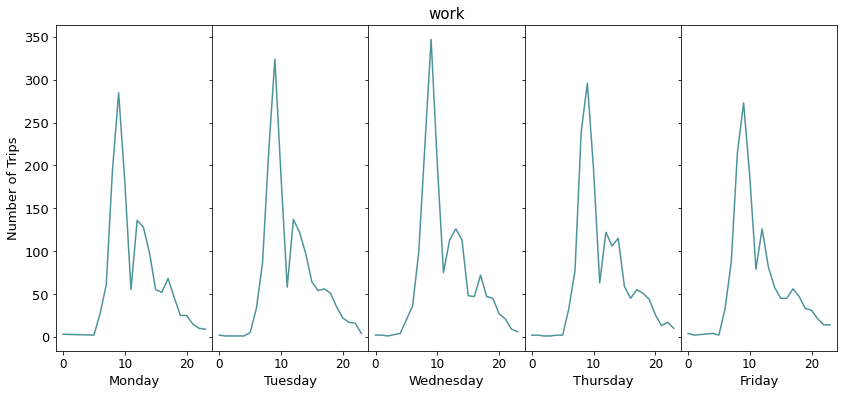

In [154]:
# plotting 

daylist = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


purpose_colors = {'education':'#916B01',
                  'work':'#4D949A', 
                  'residential': '#0F5512',
                  'medical': '#9B0000',
                  'recreational': '#009590' ,
                  'personal': '#70004B',
                  'shopping': '#878300',
                  'dining':'#C43B00', 
                  'multiple': '#000000',
                  'NA' : '#4D4D4D',
                  'transit' : '#CE4E4F'
                    }


fig, ax = plt.subplots(nrows=1, ncols=7, sharey=True, figsize=(14, 6))

for no,day in enumerate(daylist): 
    
    grouped_trips = hourly_purpose_trip_data_day.get_group(day) # change to the method. 
    
    ax[no].plot(grouped_trips['drop_time'], grouped_trips['Count'],purpose_colors[trip_purpose])

    ax[no].tick_params(axis='x', labelsize= 12)
    ax[no].set_xlabel(day, size = 13)
    fig.subplots_adjust(wspace=0)
    

ax[0].set_ylabel('Number of Trips', size = 13)
ax[0].tick_params(axis='y', labelsize= 13)
ax[3].set_title(trip_purpose, size = 15) 

plt.savefig(trip_purpose + "_temporal_regularties.jpg", bbox_inches = 'tight')

## Trip length distributions 

The length of trips should be determined by calling the OSRM API. http://project-osrm.org/docs/v5.24.0/api/. </br>

Can run either from the original API or a downloaded docker image. docker image reduces the termination of higher number of calls from the orignal to a certain extent and improves the processing time. Hence, it is advised to use a downloaded one.  

Please refer https://hub.docker.com/r/osrm/osrm-backend/ to run docker image of OSRM. 

### Route distance calculation by OSRM

In [31]:
# import the custom osrm_distance module, 
# this contains the function to calculate route distance  
import osrm_distance

# the iteration has to put to sleep after a higher number of count as the API may stop to the load, hence the time.sleep function has been used 
import time 

In [32]:
tripdata['trip_distance'] = np.nan

count = 0

for row in tripdata.itertuples(): 
   
    # distance calculation 
    trip_distance = osrm_distance.get_route(row.pickup_long,row.pickup_lat,row.dropoff_long,row.dropoff_lat)['distance']

    # distance assignment 
    tripdata.loc[row.Index,'trip_distance'] = trip_distance
    
    count = count + 1 
    
    # assess the count and put sleep after a load 
    if count == 10000:  
        time.sleep(60)
        count = 0  


### Trip length distributions estimation

Distribution plots of trip lengths for each activity/purpose is used to have an insight about descriptive informations.

Distplot function available at seaborn library is used along with KDE(Kernel Desnsity Estimation) and RUG plot to identify the distribution of trip lengths informatively.

C:\Users\HP\anaconda3\envs\GEO_NEW\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


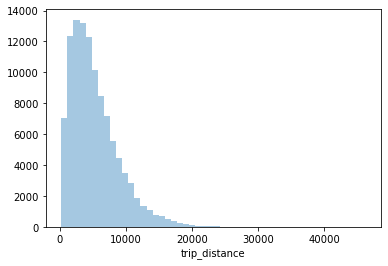

In [56]:
# population trip length distribution (depite of the activity)
ax = sns.distplot(tripdata['trip_distance'], kde=False)

In [60]:
purpose_colors = {'education':'#916B01',
                  'work':'#4D949A', 
                  'residential': '#0F5512',
                  'medical': '#9B0000',
                  'recreational': '#009590' ,
                  'personal': '#70004B',
                  'shopping': '#878300',
                  'dining':'#C43B00', 
                  'multiple': '#000000',
                  'NA' : '#4D4D4D',
                  'transit' : '#CE4E4F'
                    }

In [58]:
tripdata['Trip purpose'].unique()

array(['education', 'work', 'residential', 'NA', 'personal', 'transit',
       'medical', 'shopping', 'recreational', 'dining', 'multiple'],
      dtype=object)

C:\Users\HP\anaconda3\envs\GEO_NEW\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\envs\GEO_NEW\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
<ipython-input-91-d5c14e33d32e>:4: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('trip length distributions/'+trip_purpose+'_trip_lengths.jpg', b

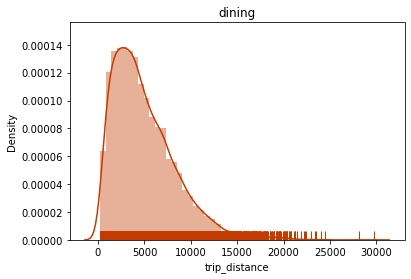

In [91]:
# sample trip length distribution (for different activities )
trip_purpose = 'dining'
ax = sns.distplot(tripdata[tripdata['Trip purpose'] == trip_purpose ]['trip_distance'], kde=True,rug = True, rug_kws= {'height' : 0.04}, color =  purpose_colors[trip_purpose] )
ax.set_title(trip_purpose)
plt.savefig('trip length distributions/'+trip_purpose+'_trip_lengths.jpg', bbox_inches = 'tight', quality = 100)

<b> Notes: </b> 

The comparison of the trip length distributions can be conducted from two approaches using the indicated analysis 

1. distribution of activity vs the total trips (sample vs population) - one sample z test 
2. distribution of activity vs distribution of another activity (sample vs sample) - two sample z test 

This analysis was conducted using the <b> "trip_length_z_test.R" </b> R file avaiable in this repositary, 

## Spatial dynamics of trips  

Extracting the dataframes based on the trip purposes to visualize through keplergl is performed in this section. 

For that purpose wise trip dataframes are saved to use seperately. 

Furthermore, to identify the trips attracted to different divisional areas, a file containing the POLYGONE type areas also need to be included to the keplergl. Hence, that is also shown in this section. https://kepler.gl/

<b> Note: </b> After extracting the data, those should be manually uploaded to the keplergl in this approach. jupyterlab extention of kepler sometimes tend to occur many depnedancy issue. Keplergl only supports CSV, GeoJSON, Json files

### Purpose wise trip file extraction 

The complete trips with purposes is divided into different dataframes and saved to different csv files 

In [26]:
tripdata['Trip purpose'].unique()

array(['education', 'work', 'residential', 'NA', 'personal', 'transit',
       'medical', 'shopping', 'recreational', 'dining', 'multiple'],
      dtype=object)

In [24]:
education = tripdata[tripdata['Trip purpose'] == 'education']
work = tripdata[tripdata['Trip purpose'] == 'work']
residential = tripdata[tripdata['Trip purpose'] == 'residential']
personal = tripdata[tripdata['Trip purpose'] == 'personal']
medical = tripdata[tripdata['Trip purpose'] == 'medical']
transit = tripdata[tripdata['Trip purpose'] == 'transit']
shopping= tripdata[tripdata['Trip purpose'] == 'shopping']
recreational = tripdata[tripdata['Trip purpose'] == 'recreational']
dining = tripdata[tripdata['Trip purpose'] == 'dining']

In [25]:
education.to_csv('purpose wise trip data/education_trips.csv')
work.to_csv('purpose wise trip data/work_trips.csv')
residential.to_csv('purpose wise trip data/residential_trips.csv')
personal.to_csv('purpose wise trip data/personal_trips.csv')
transit.to_csv('purpose wise trip data/transit_trips.csv')
medical.to_csv('purpose wise trip data/medical_trips.csv')
shopping.to_csv('purpose wise trip data/shopping_trips.csv')
recreational.to_csv('purpose wise trip data/recreational_trips.csv')
dining.to_csv('purpose wise trip data/dining_trips.csv')

### Divisional area extraction  

In [15]:
ds_divisions = pd.read_csv('divisional areas/ds_divisions_file.csv')

In [16]:
ds_divisions

Unnamed: 0        ADM3_EN      ADM3_SI          ADM3_TA ADM3_PCODE  \
0             0      [unknown]    [unknown]        [unknown]     LK4100   
1             1      [unknown]    [unknown]        [unknown]     LK5100   
2             2      [unknown]    [unknown]        [unknown]     LK6000   
3             3  Addalaichenai  අඩ්ඩාලච්චේන    அட்டாளைச்சேனை     LK5233   
4             4     Agalawatta      අගලවත්ත         அகலவத்தை     LK1333   
..          ...            ...          ...              ...        ...   
328         328      Wilgamuwa     විල්ගමුව        வில்கமுவை     LK2227   
329         329   Yakkalamulla   යක්කලමුල්ල      யக்கலமுல்லை     LK3148   
330         330      Yatawatta       යටවත්ත        யட்டவத்தை     LK2215   
331         331     Yatinuwara      යටිනුවර       யட்டிநுவரை     LK2136   
332         332    Yatiyantota    යටියන්තොට  எட்டியாந்தோட்டை     LK9227   

     ADM3_REF  ADM3ALT1EN  ADM3ALT2EN  ADM3ALT1SI  ADM3ALT2SI  ...    ADM0_EN  \
0         NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
1         NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
2         NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
3         NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
4         NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
..        ...         ...         ...         ...         ...  ...        ...   
328       NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
329       NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
330       NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
331       NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   
332       NaN         NaN         NaN         NaN         NaN  ...  Sri Lanka   

        ADM0_SI ADM0_TA ADM0_PCODE Shape_Leng Shape_Area        date  \
0    ශ්‍රී ලංකා  இலங்கை         LK   0.041858   0.000077  2019-03-04   
1    ශ්‍රී ලංකා  இலங்கை         LK   0.436271   0.000715  2019-03-04   
2    ශ්‍රී ලංකා  இலங்கை         LK   0.286741   0.002137  2019-03-04   
3    ශ්‍රී ලංකා  இலங்கை         LK   0.445924   0.006093  2019-03-04   
4    ශ්‍රී ලංකා  இலங்கை         LK   0.636129   0.007542  2019-03-04   
..          ...     ...        ...        ...        ...         ...   
328  ශ්‍රී ලංකා  இலங்கை         LK   0.747284   0.023836  2019-03-04   
329  ශ්‍රී ලංකා  இலங்கை         LK   0.571012   0.008880  2019-03-04   
330  ශ්‍රී ලංකා  இலங்கை         LK   0.479125   0.005522  2019-03-04   
331  ශ්‍රී ලංකා  இலங்கை         LK   0.436942   0.005660  2019-03-04   
332  ශ්‍රී ලංකා  இலங்கை         LK   0.962485   0.014727  2019-03-04   

        validOn validTo                                           geometry  
0    2020-03-05     NaN  POLYGON ((80.25376864900005 9.621723773000042,...  
1    2020-03-05     NaN  MULTIPOLYGON (((81.64758189400004 7.5061070160...  
2    2020-03-05     NaN  POLYGON ((79.80302707600003 7.850300127000025,...  
3    2020-03-05     NaN  POLYGON ((81.85586541800006 7.302516421000064,...  
4    2020-03-05     NaN  POLYGON ((80.18546666500004 6.581113175000041,...  
..          ...     ...                                                ...  
328  2020-03-05     NaN  POLYGON ((80.98655548700003 7.719505532000028,...  
329  2020-03-05     NaN  POLYGON ((80.37493498700007 6.165930149000076,...  
330  2020-03-05     NaN  MULTIPOLYGON (((80.58301988600005 7.6002289350...  
331  2020-03-05     NaN  POLYGON ((80.56603181200006 7.319222513000057,...  
332  2020-03-05     NaN  MULTIPOLYGON (((80.41030847600007 7.0811228490...  

[333 rows x 30 columns]

In [22]:
# select the required ds divisons 
required_divisons_list = ['Dehiwala','Thimbirigasyaya','Sri Jayawardanapura Kotte']
required_divisons = ds_divisions[ds_divisions['ADM3_EN'].isin(required_divisons_list)]
required_divisons.to_csv('divisional areas/required_ds_divisions.csv')

In [23]:
# select the required ds divisons seperately 
dehiwala_division = ds_divisions[ds_divisions['ADM3_EN'] == 'Dehiwala']
thimbirigasyaya_division = ds_divisions[ds_divisions['ADM3_EN'] == 'Thimbirigasyaya']
kotte_division = ds_divisions[ds_divisions['ADM3_EN'] == 'Sri Jayawardanapura Kotte']

dehiwala_division.to_csv('divisional areas/Dehiwala_divisions.csv')
thimbirigasyaya_division.to_csv('divisional areas/Thimbirigasyaya_divisions.csv')
kotte_division .to_csv('divisional areas/Kotte_divisions.csv')

Input the data to https://kepler.gl/ to visulize the spatial dynamics. Use of colored hexagons for densities of drop off points helps to identify the areas with higher trip attraction for a defined trip purpose. 

The following images shows examples of identified spatial dynamics for a purpose.

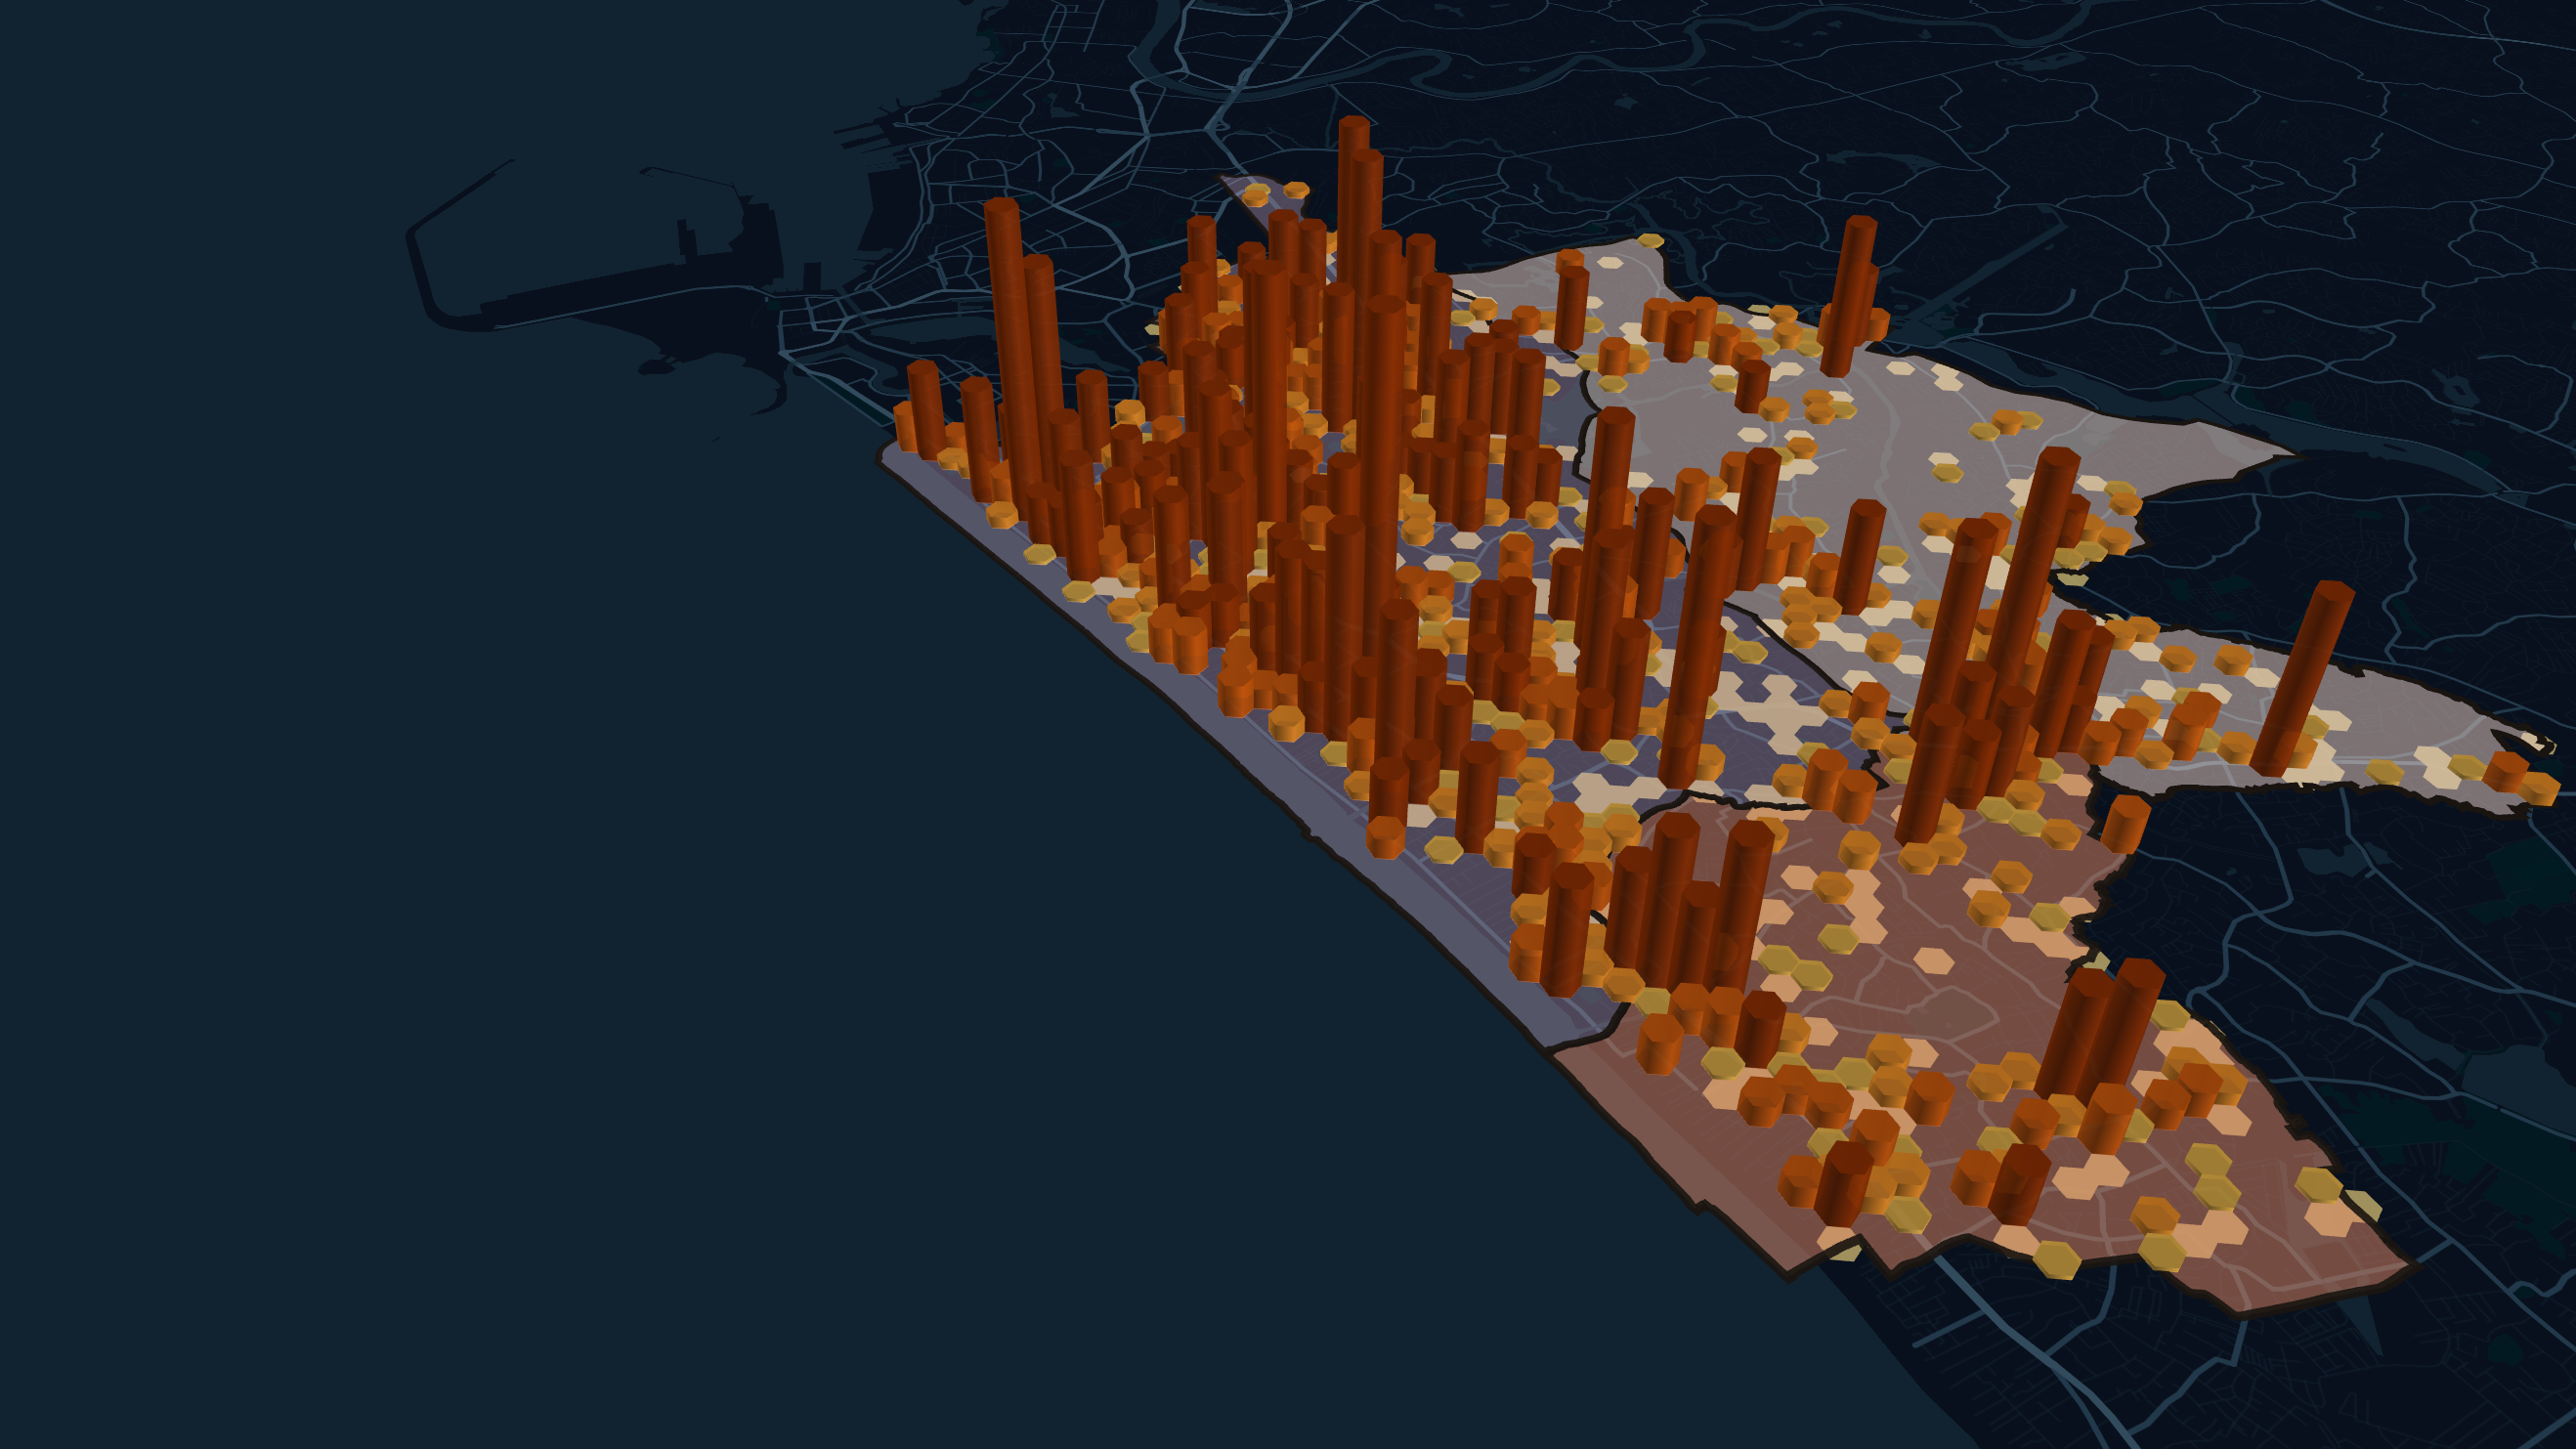

In [1]:
from IPython.display import Image
Image(filename='spatial dynamics/educational.png') 

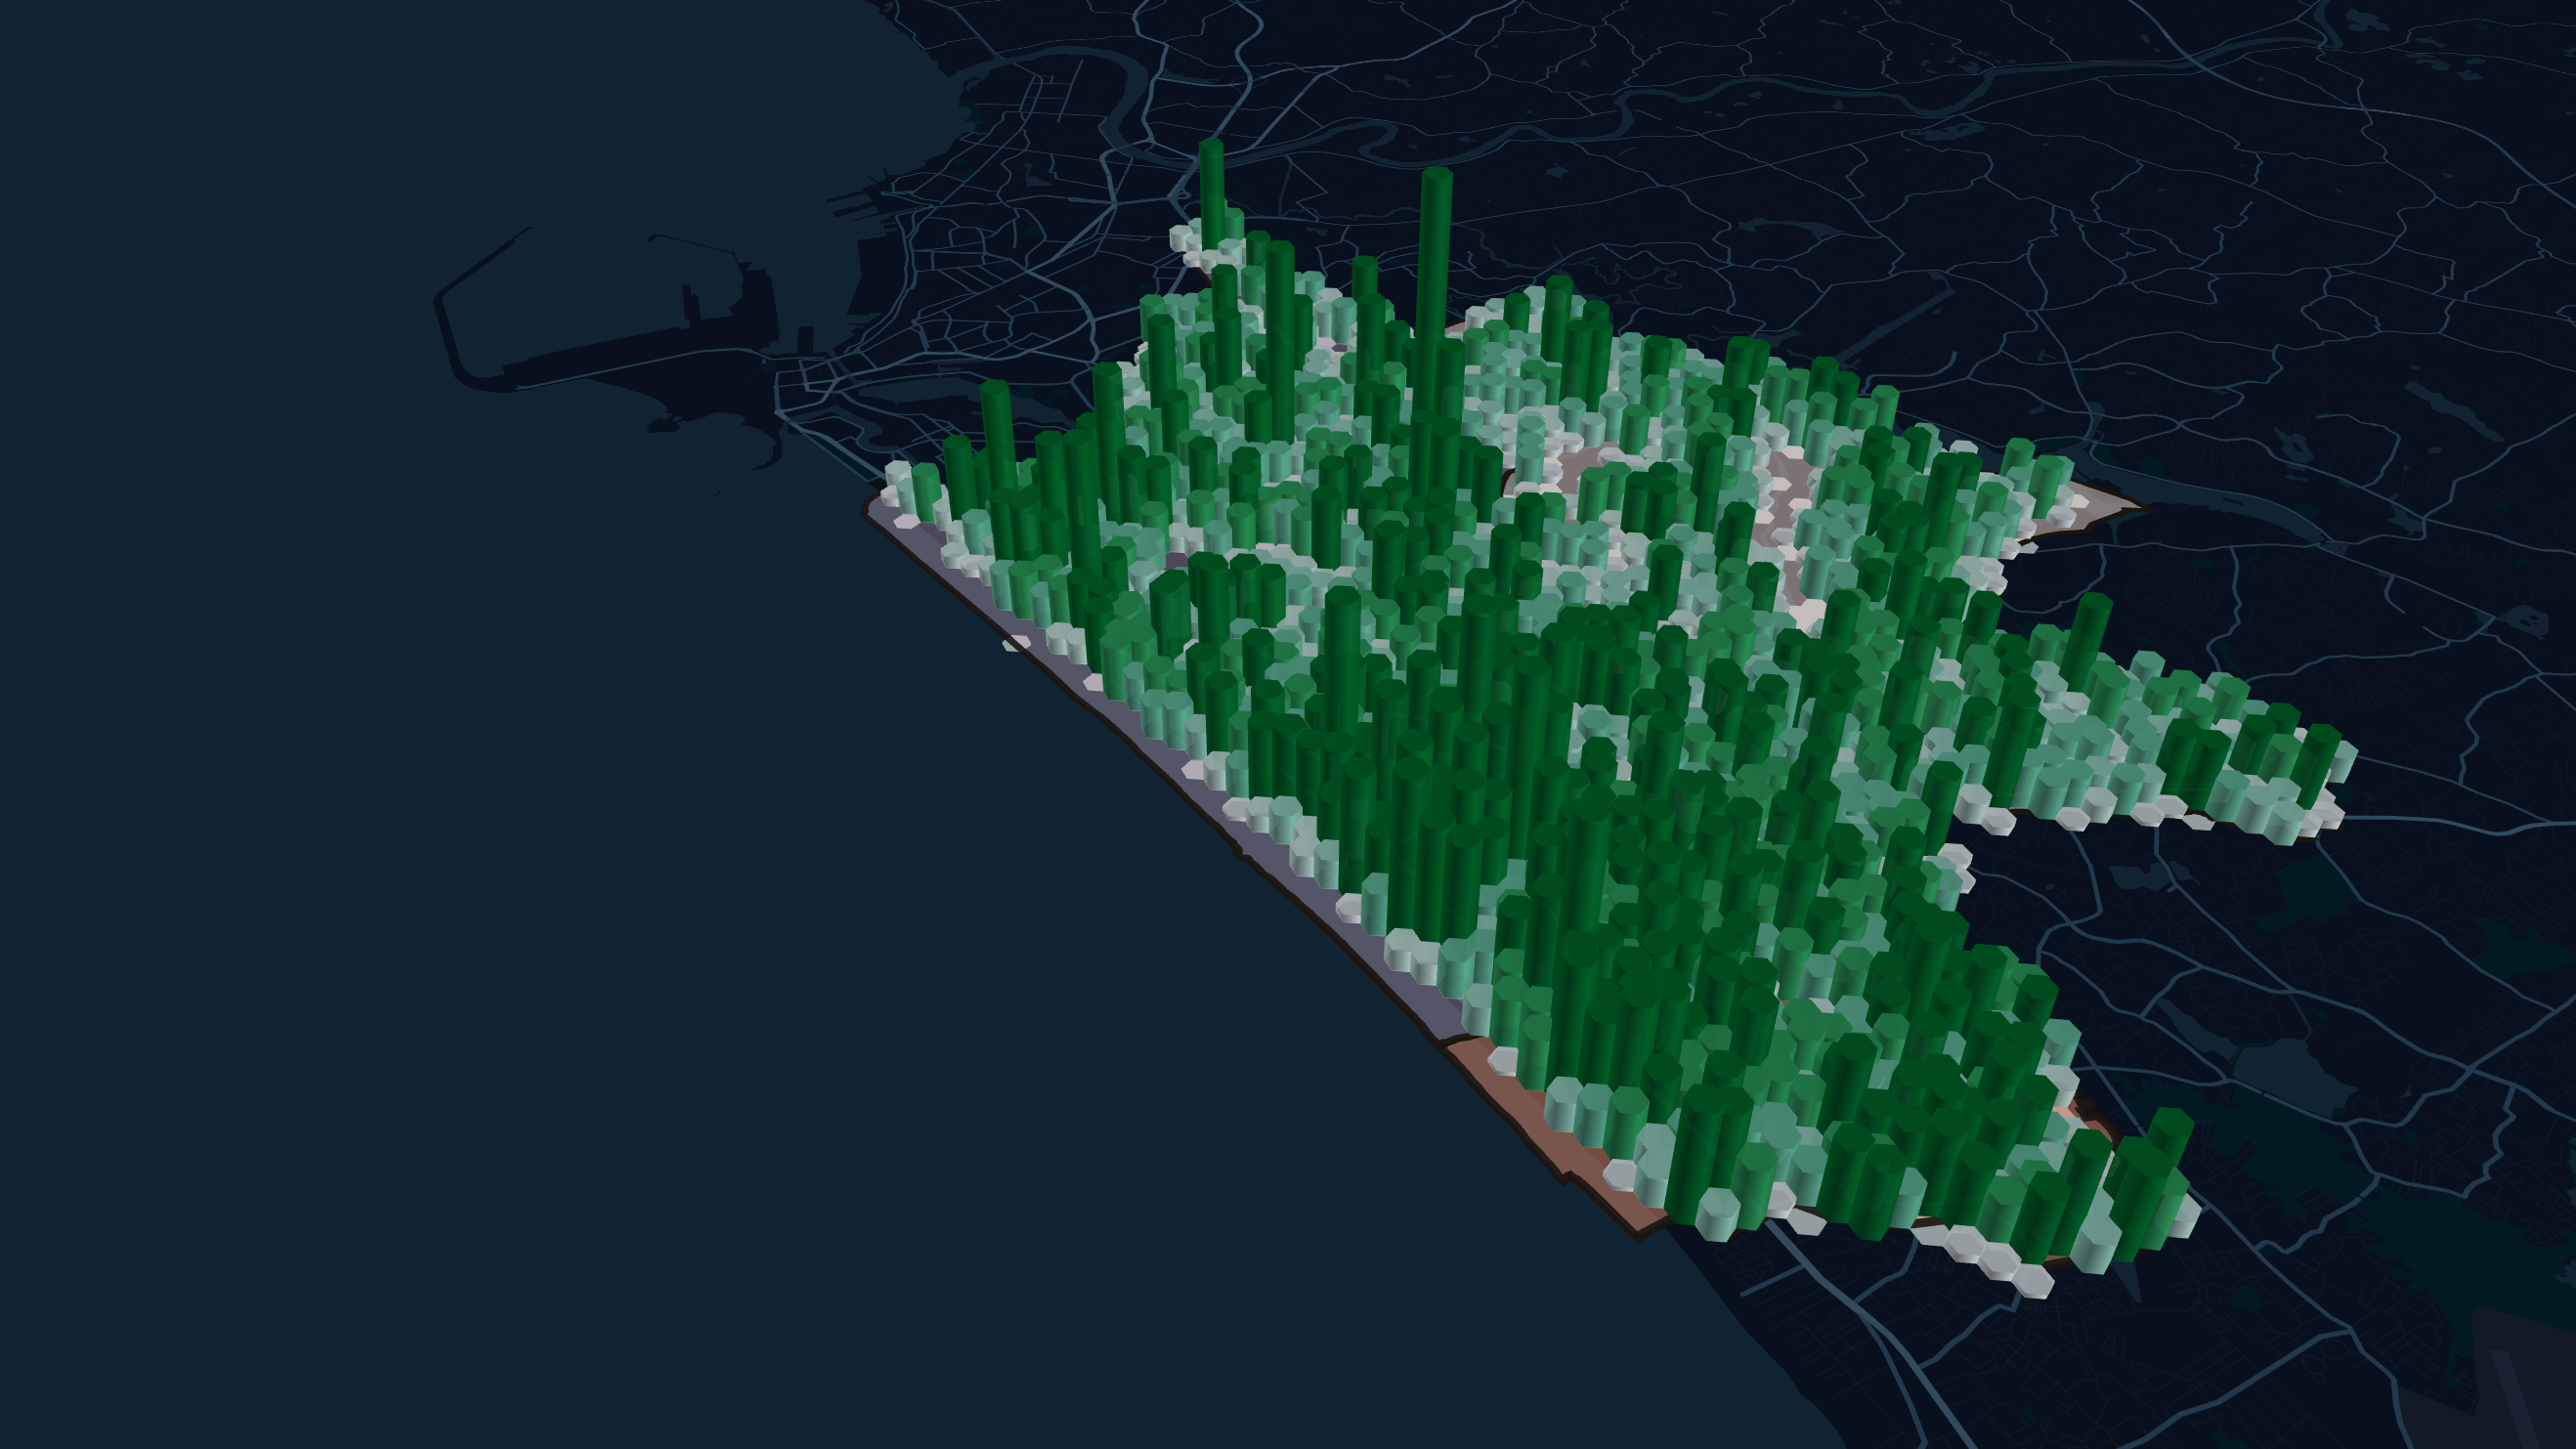

In [29]:
Image(filename='spatial dynamics/residential.png') 